# Solving vanilla European options of Black-Scholes equation with Physics-informed Neural Networks

Recall that if we are using the Black-Scholes option pricing model then its value can be modeled as a function $V(S,t)$ that follows the PDE

$$\begin{align*}
    \frac{\partial V}{\partial t} + \frac{\sigma^2S^2}{2} \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{align*}$$
with the price $S$, risk-free rate $r$ and (fixed) volatility $\sigma$. This PDE is not meant to be solved forward in time since in most cases, we know how the payoff looks like at maturity so the question is to see how we can price the option right now (or at the inital time). In other words, this is a terminal value problem. Note that if we have a maturity time $t = T$ then by the change of variable $\tau = T - t$ then we can reduce the problem down to an initial value problem. This notebook will explore solving this setup with Physics-informed Neural Network (PINN) with respect to the vanilla European call options $V(S,T) = \max(S-K,0)$ for the strike price $K$. 

All of this means we training a Neural Network to solve the differential equation $V(S,\tau)$ on the time-evolution domain $[S_{min}, S_{max}] \times [0,T]$ of the following form 
$$\begin{align*}
    -\frac{\partial V}{\partial \tau} + \frac{\sigma^2S^2}{2} \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 
\end{align*}$$
with the boundary conditions
$$\begin{align*}
    & V(S,0) = \max(S-K, 0) \\
    & V(S_{max}, \tau) = S_{max} - Ke^{-r\tau} \\
    & V(S_{min}, \tau) = 0
\end{align*}$$
Even though the inputs is meant to be of the form $(S,\tau)$, we to make it consistent with the original formulation, the inputs will be $(S,t)$ and the variable change $t \to \tau$ will be made internally of the model before training and predicting.

On the implementation side, for the architecture, instead of the usual multi layer perceptron (MLP), the Kolmogorov-Arnold Network (KAN) will since this notebook project goal is 2-fold for me which is understand the dynamics of the Black-Scholes model while also gain some intuition and exposure to the KAN network.

Of course, to test the performance of the model, we will benchmark it against the known analytical solution 
$$\begin{align*}
    V_{analytical}(S,t) = S\Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-)
\end{align*}$$
where $\Phi(z)$ is the cummulative distribution function (CDF) of the standard normal distribution and 
$$\begin{align*}
    d_+ = \frac{1}{\sigma\sqrt{T-t}} \left( \ln\left(\frac{S}{K}\right) + t\left(\frac{r + \frac{\sigma^2}{2}}{2}\right) \right) \qquad \text{with} \qquad d_- = d_+ - \sigma\sqrt{t}
\end{align*}$$

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN
import torch.optim as optim
from scipy.stats import norm
import seaborn as sns

import sys
sys.dont_write_bytecode = True
sys.path.insert(1, "../../src/")
from PINN import BlackScholesPINN as BlackScholesPINN

In [3]:
# Backend setup 
torch.cuda.empty_cache()
# Set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

# CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# (Static) parameters that setup the Black-Scholes problem
# It can be a nice exercise in the future (if I ever revisit) is to pull market data and update the paramter based on the real data

param = {
    "Risk-free rate": 0.1,      # r
    "Volatility"    : 0.01,     # sigma
    "Strike price"  : 100,      # K
    "Price range"   : [50,150], # [S_min, S_max]
    "Time range"    : [0,0.25]  # [t_0, T]
}

# Paramters to set up the KAN feedforward network
KAN_param = {
    "Layers"        : [2,32,32,32,32,1],
    "Grid size"     : 10,
    "Spline order"  : 5,
    "Learning rate" : 1e-3,
    "Model path"    : "Black-scholes-EU-call-KAN-pinn.pth"
}

Note that even though the paramters chosen here are static, they were deliberately chosen since according to this [paper](https://faculty.haas.berkeley.edu/walden/HaasWebpage/benchop.pdf), these paramters will give a more challenging setting with respect to developing numerical models for Black-Scholes.

In [5]:
# Boundary conditions for the Black-Scholes model
# This will implement the European call option
def terminal_condition(S,K):
    return torch.maximum(S-K , torch.zeros_like(S))

def max_boundary(S_max, K, r, T ,t):
    return S_max - K*torch.exp(-r*(T-t))

def min_boundary(t):
    return torch.zeros_like(t)

conditions = {
    "Terminal condition": terminal_condition,
    "Max boundary"      : max_boundary,
    "Min boundary"      : min_boundary
}

In [6]:
# Create the PINN class
BSP = BlackScholesPINN(param=param, KAN_param=KAN_param, conditions=conditions, device=device)

In [ ]:
BSP.train(epochs=3001, print_interval=300)

Epoch    0: Total Loss = 39786.914062 | Residual loss = 0.000064 | Termial loss = 404.141510 | Max Price loss = 2517.740234 | Min Price Loss = 0.105099 | MSE: 2921.986816
Epoch  300: Total Loss = 443.268463 | Residual loss = 0.406774 | Termial loss = 80.386658 | Max Price loss = 2.010309 | Min Price Loss = 3.045074 | MSE: 85.848816
Epoch  600: Total Loss = 6.819295 | Residual loss = 0.023381 | Termial loss = 0.485949 | Max Price loss = 0.258823 | Min Price Loss = 0.039586 | MSE: 0.807739
Epoch  900: Total Loss = 1.230424 | Residual loss = 0.012662 | Termial loss = 0.071714 | Max Price loss = 0.040965 | Min Price Loss = 0.004155 | MSE: 0.129495
Epoch 1200: Total Loss = 2.239472 | Residual loss = 0.002807 | Termial loss = 0.028985 | Max Price loss = 0.135892 | Min Price Loss = 0.000028 | MSE: 0.167712
Epoch 1500: Total Loss = 0.105999 | Residual loss = 0.002028 | Termial loss = 0.008804 | Max Price loss = 0.001411 | Min Price Loss = 0.000251 | MSE: 0.012494
Epoch 1800: Total Loss = 0.056

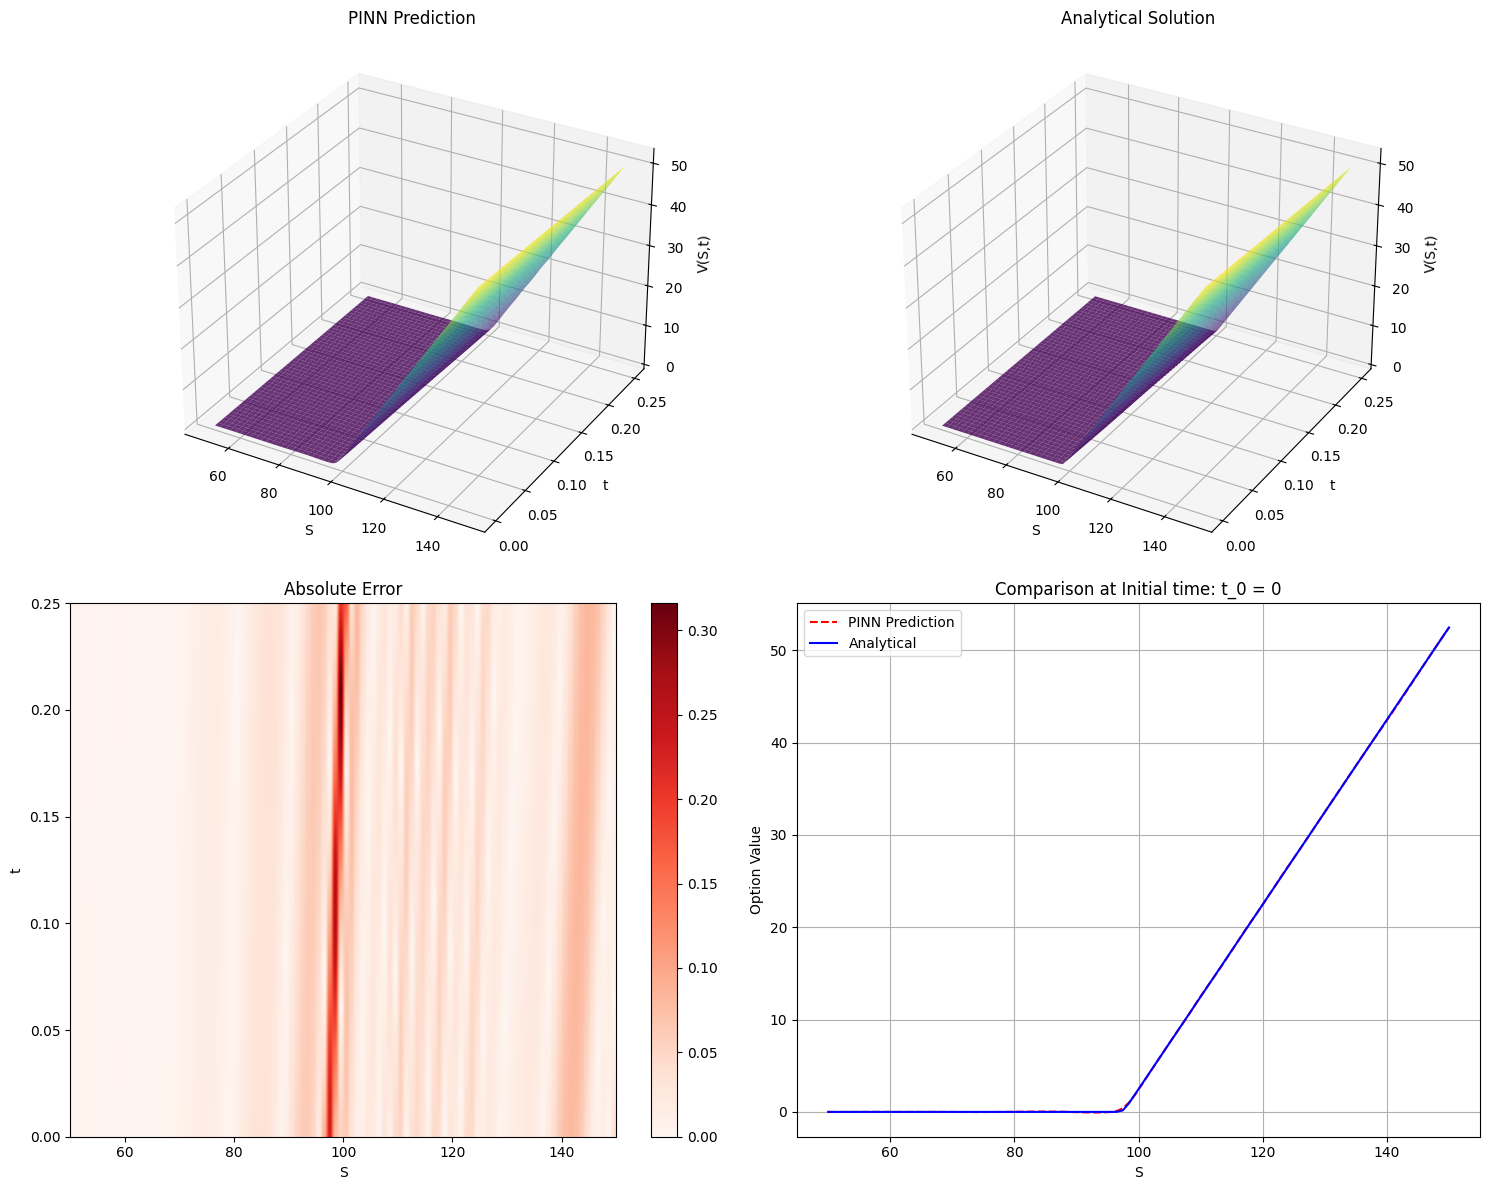

Error for prediction throughout whole time-evolution grid
Maximum absolute error: 0.316055
Mean absolute error: 0.025328
Root Mean Square Error: 0.041310
Relative error (% of mean option value): 0.19%

Error for prediction at t_0 = 0.00
Maximum absolute error: 0.231344
Mean absolute error: 0.024547
Root Mean Square Error: 0.038828
Relative error (% of mean option value): 0.18%

Maximum error location:  S = 99.49, t = 0.2065


In [7]:
BSP.benchmark(n_price_points=100, n_time_points=300)

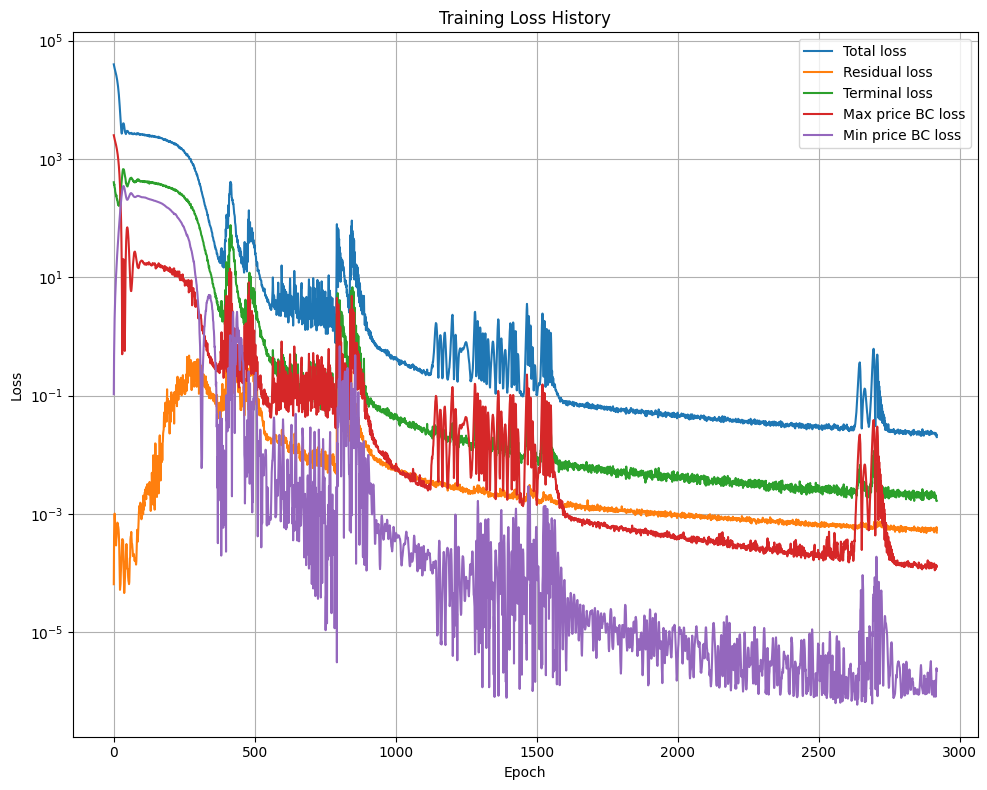

In [8]:
BSP.plot_training_stats()

The produced model in the end is a pretty good model, and of course as expected the location with the most error is near the strike price since that is the location with sharp gradients and PINNs (or Neural Networks more generally) are known for the tendancy to fit smooth functions and can not deal with singularities well.

In [10]:
BSP.load_model(BSP.model_path)

S_list = {75, 100, 125, 150}
for S in S_list:
    S = torch.tensor([[float(S)]], device=device)
    t = torch.tensor([[float(0)]], device=device)
    print( (BSP.predict(S,t).item() , BSP.analytical_solution(S,t).item()) )

(-0.015356063842773438, 0.0)
(2.3992414474487305, 2.4690170288085938)
(27.472652435302734, 27.469009399414062)
(52.430397033691406, 52.46900939941406)
